In [50]:
!python3.11 -m pip install pandas
!python3.11 -m pip install timm opencv-python torch urllib3 matplotlib
!python3.11 -m pip install numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [51]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /Users/adamrolander/.cache/torch/hub/intel-isl_MiDaS_master


In [52]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [53]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/adamrolander/.cache/torch/hub/intel-isl_MiDaS_master


In [70]:
img = cv2.imread("SS1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [71]:
original_image = cv2.imread("SS1.png")

In [72]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

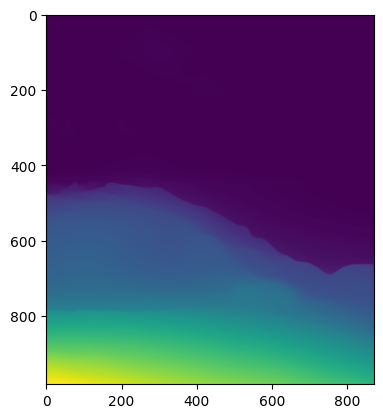

In [73]:
plt.imshow(output)

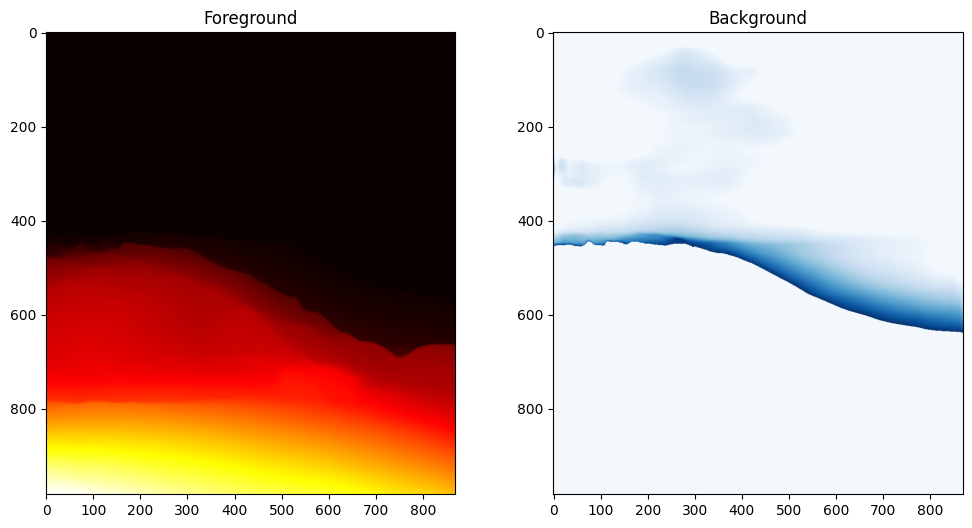

In [74]:
import numpy as np

# Assuming depth_map is already loaded
depth_map = np.array(output)  # Your depth map (np.array format)

# Define thresholds for segmentation (you can adjust based on your scene)
near_threshold = 0.5  # Anything greater than this will be considered as foreground
far_threshold = 1.5  # Background threshold

# Create binary masks based on thresholds
foreground_mask = depth_map > near_threshold
background_mask = depth_map < far_threshold

# Apply masks to isolate regions
foreground = np.copy(depth_map)
foreground[~foreground_mask] = 0  # Set background to 0

background = np.copy(depth_map)
background[~background_mask] = 0  # Set foreground to 0

# Visualize the segmented regions
plt.figure(figsize=(12, 6))

# Plotting foreground vs background segmentation
plt.subplot(1, 2, 1)
plt.imshow(foreground, cmap='hot')
plt.title('Foreground')

plt.subplot(1, 2, 2)
plt.imshow(background, cmap='Blues')
plt.title('Background')

plt.show()

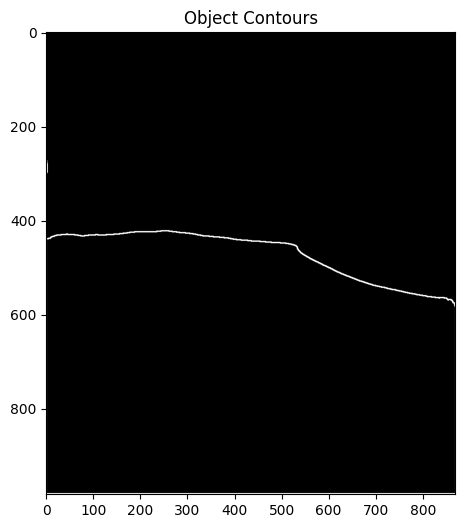

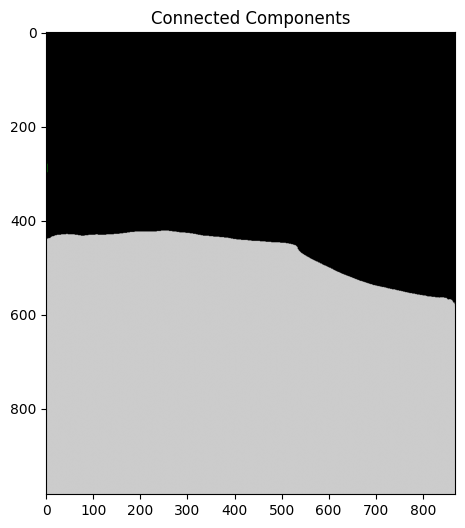

In [75]:
foreground_mask = foreground_mask.astype(np.uint8) * 255  # Convert to uint8 for OpenCV

# Finding contours in the foreground mask
contours, _ = cv2.findContours(foreground_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty image to draw the contours
contour_image = np.zeros_like(foreground_mask)

# Draw contours on the image
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)

# Visualize the contours
plt.figure(figsize=(6, 6))
plt.imshow(contour_image, cmap='gray')
plt.title('Object Contours')
plt.show()

# Optional: Apply connected components to segment further
# This will label each connected object with a unique integer
num_labels, labels = cv2.connectedComponents(foreground_mask)

# Visualize connected components
plt.figure(figsize=(6, 6))
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Connected Components')
plt.show()

In [60]:
%pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [66]:
import numpy as np
import cv2
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Assuming you already have `contour_image` from the previous step, and the original image `original_image`
# Convert original image to RGB if necessary
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Create a list to hold the extracted regions
extracted_regions = []

# Loop through each contour
for contour in contours:
    # Create a mask for each contour
    mask = np.zeros_like(foreground_mask, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    
    # Apply the mask to the original image to extract the region
    masked_region = cv2.bitwise_and(original_image_rgb, original_image_rgb, mask=mask)
    
    # Crop the region (bounding box)
    x, y, w, h = cv2.boundingRect(contour)
    cropped_region = masked_region[y:y+h, x:x+w]
    
    # Append the cropped region to the list
    extracted_regions.append(cropped_region)

# Now `extracted_regions` contains all the segmented parts of the image.

In [67]:
class_labels = ["ocean", "sky", "rock", "hill", "sand", "sunset"]

# Create a list to store the predictions
predictions = []

# Loop through each extracted region and classify it
for region in extracted_regions:
    # Convert the region to PIL Image
    region_pil = Image.fromarray(region)
    
    # Preprocess the image and text inputs for CLIP
    inputs = processor(images=region_pil, text=class_labels, return_tensors="pt", padding=True)
    
    # Get CLIP model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1)  # Get probabilities
        
    # Get the predicted class label
    predicted_label = class_labels[torch.argmax(probs)]
    predictions.append(predicted_label)

# Print the predictions
print(predictions)

['hill', 'sky']


(982, 870, 3)
2563020
(982, 870)
(982, 870)
['sand', 'sky']


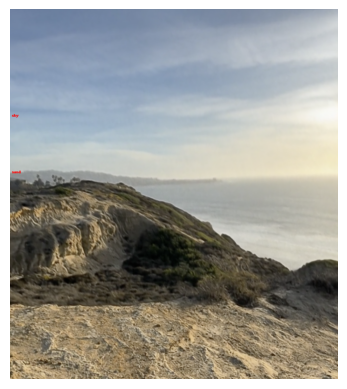

In [76]:
import numpy as np
import cv2
import torch
from PIL import Image, ImageDraw
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# Load CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Assuming you already have `contour_image` from the previous step, and the original image `original_image`
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Ensure the image is 3-channel (RGB) and the mask is single-channel (grayscale)
if original_image_rgb.ndim != 3 or original_image_rgb.shape[2] != 3:
    raise ValueError("The original image must be a 3-channel (RGB) image")

print(original_image_rgb.shape)  # (height, width, 3)
print(original_image.size)  # Check PIL image size

# Define classification labels
class_labels = ["ocean", "sky", "rock", "hill", "sand", "sunset"]

# Create a list to store the predictions
predictions = []

# Create a copy of the original image for drawing
image_copy = Image.fromarray(original_image_rgb)

# Loop through each contour and classify the regions
for contour in contours:
    # Create a mask for each contour with the same size as the original image
    mask = np.zeros_like(original_image_rgb[:, :, 0], dtype=np.uint8)  # Single-channel mask
    
    # Draw the contour onto the mask
    cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    
    print(mask.shape)  # Ensure this is (height, width)

    # Apply the mask to the original image to extract the region
    masked_region = cv2.bitwise_and(original_image_rgb, original_image_rgb, mask=mask)

    # Crop the region (bounding box)
    x, y, w, h = cv2.boundingRect(contour)
    cropped_region = masked_region[y:y+h, x:x+w]
    
    # Convert the cropped region to PIL Image
    region_pil = Image.fromarray(cropped_region)
    
    # Preprocess the image and text inputs for CLIP
    inputs = processor(images=region_pil, text=class_labels, return_tensors="pt", padding=True)
    
    # Get CLIP model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1)  # Get probabilities
        
    # Get the predicted class label
    predicted_label = class_labels[torch.argmax(probs)]
    predictions.append(predicted_label)
    
    # Draw the predicted label on the copied image
    draw = ImageDraw.Draw(image_copy)
    draw.text((x + 5, y + 5), predicted_label, fill="red")  # Position the label on the contour area

# Print the predictions
print(predictions)

# Display the image with labels
plt.imshow(image_copy)
plt.axis("off")
plt.show()

In [100]:
!git clone https://github.com/facebookresearch/sam2.git && cd sam2 && pip install -e .

Cloning into 'sam2'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 3.04 MiB/s, done.
Resolving deltas: 100% (376/376), done.
Obtaining file:///Users/adamrolander/UEAI/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-py3-none-any.whl size=13803 sha256=1b5a778eb18a9332fbd7ef5fe31490528b8489d3401e45d10e5e590729d4cd28
  Stored in directory: /private/var/folders/wg/nhgqjkwd1jd13yd4pxvvrrzm0000gn/T/pip-ephem-wheel-cache-0946e77j/wheels/bf/c9/44/57fc41f0337ddc0bbf91e3c3e65a89a404c97cfa74149951c6
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
   

In [104]:
import torch
import sys

from sam2_repo.sam2.build_sam import build_sam2
from sam2_repo.sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

ModuleNotFoundError: No module named 'sam2.modeling'